In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       

import sys

In [2]:
def new_calc_dx_dy(longitude,latitude,shape,radius=6371000.):
    ''' This definition calculates the distance 
        between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes 
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D arrays for latitude and longitude
        
        Returns: dx, dy; 2D arrays of distances 
                       between grid points in the x and y direction in meters 
        https://github.com/Unidata/MetPy/issues/288
    '''
    from pyproj import Geod
    
    if (radius != 6371000.):
        g = Geod(a=radius,b=radius)
    else:
        g = Geod(ellps=shape)
    
    dx = np.empty(latitude.shape)
    dy = np.zeros(longitude.shape)
    
    for i in range(latitude.shape[1]):
        for j in range(latitude.shape[0]-1):
            _, _, dx[j,i] = g.inv(longitude[j,i],latitude[j,i],longitude[j+1,i],latitude[j+1,i])
    dx[j+1,:] = dx[j,:]
    
    for i in range(latitude.shape[1]-1):
        for j in range(latitude.shape[0]):
            _, _, dy[j,i] = g.inv(longitude[j,i],latitude[j,i],longitude[j,i+1],latitude[j,i+1])
    dy[:,i+1] = dy[:,i]
    
    return dx, dy

In [3]:
def run_lifecycle_HW(flag,variable):
        """
        Life cycle analysis: Tracking of intensity, spatial extent and center of mass of each flagged contour.
        ## For Heat waves, return floating values of lat/lon related to the center of mass.
        Parameters
        ----------
            flag : string
                input variable with flags, output of run_contrack()
            variable : string
                input variable used to calculate intensity and center of mass

        Returns
        -------
            pandas dataframe: DataFrame
                tracking of characteristics for each flagged contour
                ['Flag','Date [YYYMMDD_HH]','Longitude [°E]','Latitude [°N]','Intensity [unit from variable]','Size [km2]']
        """
        if (flag.lat[0] > flag.lat[1]):
            raise Exception("Latitude should be ascending order")
            
        xlon, ylat = np.meshgrid(flag.lon, flag.lat) 
        test_lon, test_lat = new_calc_dx_dy(xlon, ylat,shape='WGS84')
        area = test_lon*test_lat
        print(area.shape)

        # define grid weight (Modified from original CONTRACK)
#         weight_lat  = np.cos(flag.lat.data*np.pi/180)
        weight_grid = np.ones((flag.shape[1], flag.shape[2]))*np.array(area).astype(np.float32)/1e6

        # define output
        #initialize wanted variables!!!!!!
        block_id = []
        time = []
        intensity = []
        size = []
        com_lon = []
        com_lat = []
   
        # loop through time
        for i_time in tqdm(range(flag.shape[0]),desc = 'tqdm() Progress Bar'): 

            currentstep = flag.time[i_time].dt.strftime('%Y%m%d').values
            
            # loop over individual contours
            labels = np.unique(flag.isel(**{'time': i_time}).data)
            labels = labels[labels != 0]
            if len(labels) == 0:
                #no flag at this timestep
                continue

            for label in labels:
                
                # calculate area and intensity
                areacon = np.sum(weight_grid[flag.isel(**{'time': i_time}).data == label])
                intensitycon = np.sum(weight_grid[flag.isel(**{'time': i_time}).data == label] * variable.isel(**{'time': i_time}).data[flag.isel(**{'time': i_time}).data == label])
                intensitycon = intensitycon/areacon

                #print(intensitycon)
                
                # calculate center of mass
                # periodic boundary: roll field if flag is split at boundary
                if label in flag.isel(**{'time': i_time, 'lon':0}).data and label in flag.isel(**{'time': i_time, 'lon':-1}).data:
                    # find western edge of flag
                    yloc, xloc = np.where(flag.isel(**{'time': i_time}).data == label)
                    lon_roll = np.unique(xloc)[np.argmax(np.diff(np.unique(xloc)))+1]
                    flag_roll = flag.isel(**{'time': i_time}).roll(**{'lon':(-1) * lon_roll},roll_coords=True)
                    variable_roll = variable.isel(**{'time': i_time}).roll(**{'lon':(-1) * lon_roll},roll_coords=True)
                    center_of_mass = ndimage.center_of_mass(variable_roll.data*weight_grid, flag_roll.data, [label])
                    
                    comlatcon = flag_roll.lat[int(center_of_mass[0][0])].data
                    comloncon = flag_roll.lon[int(center_of_mass[0][1])].data
                    
                else:
                    center_of_mass = ndimage.center_of_mass(variable.isel(**{'time': i_time}).data*weight_grid, flag.isel(**{'time': i_time}).data, [label])
#                    print(center_of_mass)

                    comlatcon = flag.lat[int(center_of_mass[0][0])].data
                    comloncon = flag.lon[int(center_of_mass[0][1])].data

                             
                # append to output list
                block_id.append(label)
                time.append(str(currentstep))                
                intensity.append(round(intensitycon,2))
                size.append(round(areacon,2))
                com_lon.append(comloncon)
                com_lat.append(comlatcon)             
                           
        return pd.DataFrame(sorted(list(zip(block_id,time,com_lon,com_lat,intensity,size)), key=lambda x: (x[0], x[1])) , columns=['Flag','Date','Longitude','Latitude','Intensity','Size'])

In [4]:
def worldmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)


In [5]:
col_url = "/home/tmerlis/hackathon/catbuild/xsh24_cat.json"

In [6]:
col = intake.open_esm_datastore(col_url)

In [7]:
col.df

,source_id,experiment_id,frequency,realm,table_id,member_id,grid_label,variable_id,time_range,chunk_freq,platform,path
0,NaN,20191020.00Z.C3072.xs24v2,NaN,NaN,NaN,GLOBALFV3,NaN,tro_pbl_age_C3072_11520x5760,2020022200,NaN,cimes,/scratch/cimes/GLOBALFV3/20191020.00Z.C3072.xs...
1,NaN,20191020.00Z.C3072.xs24v2,NaN,NaN,NaN,GLOBALFV3,NaN,vs_coarse_C3072_1440x720,2020022200,NaN,cimes,/scratch/cimes/GLOBALFV3/20191020.00Z.C3072.xs...
2,NaN,20191020.00Z.C3072.xs24v2,NaN,NaN,NaN,GLOBALFV3,NaN,pk_C3072_11520x5760,2020022200,NaN,cimes,/scratch/cimes/GLOBALFV3/20191020.00Z.C3072.xs...
3,NaN,20191020.00Z.C3072.xs24v2,NaN,NaN,NaN,GLOBALFV3,NaN,int_liq_wat_dt_phys_coarse_C3072_1440x720,2020022200,NaN,cimes,/scratch/cimes/GLOBALFV3/20191020.00Z.C3072.xs...
4,NaN,20191020.00Z.C3072.xs24v2,NaN,NaN,NaN,GLOBALFV3,NaN,clisccp_05_05_coarse_C3072_1440x720,2020022200,NaN,cimes,/scratch/cimes/GLOBALFV3/20191020.00Z.C3072.xs...
...,...,...,...,...,...,...,...,...,...,...,...,...
23905,NaN,20191020.00Z.C3072.xs24v2,NaN,NaN,NaN,GLOBALFV3,NaN,o3mr_coarse_C3072_1440x720,2020092900,NaN,cimes,/scratch/cimes/GLOBALFV3/20191020.00Z.C3072.xs...
23906,NaN,20191020.00Z.C3072.xs24v2,NaN,NaN,NaN,GLOBALFV3,NaN,g_accr_C3072_11520x5760,2020092900,NaN,cimes,/scratch/cimes/GLOBALFV3/20191020.00Z.C3072.xs...
23907,NaN,20191020.00Z.C3072.xs24v2,NaN,NaN,NaN,GLOBALFV3,NaN,h_plev_coarse_C3072_1440x720,2020092900,NaN,cimes,/scratch/cimes/GLOBALFV3/20191020.00Z.C3072.xs...
23908,NaN,20191020.00Z.C3072.xs24v2,NaN,NaN,NaN,GLOBALFV3,NaN,int_u_dt_phys_coarse_C3072_1440x720,2020092900,NaN,cimes,/scratch/cimes/GLOBALFV3/20191020.00Z.C3072.xs...


In [8]:
# np.unique(col.df.variable_id)

In [9]:
cat = col.search(variable_id = 'h_plev_coarse_C3072_1440x720')

In [10]:
print(cat)

<esm_catalog_ESM4 catalog with 1 dataset(s) from 89 asset(s)>


In [11]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time':5}, 'decode_times': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'


In [12]:
dset_dict

{'20191020.00Z.C3072.xs24v2.GLOBALFV3': <xarray.Dataset> Size: 458GB
 Dimensions:              (time: 3560, plev: 31, grid_yt_coarse: 720, bnds: 2,
                           grid_xt_coarse: 1440)
 Coordinates:
   * time                 (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-0...
   * plev                 (plev) float32 124B 1.0 2.0 3.0 ... 950.0 975.0 1e+03
   * grid_yt_coarse       (grid_yt_coarse) float32 3kB -89.88 -89.62 ... 89.88
     grid_yt_coarse_bnds  (grid_yt_coarse, bnds) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
   * grid_xt_coarse       (grid_xt_coarse) float32 6kB 0.125 0.375 ... 359.9
     grid_xt_coarse_bnds  (grid_xt_coarse, bnds) float32 12kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
     h_plev_coarse        (time, plev, grid_yt_coarse, grid_xt_coarse) float32 458GB dask.array<chunksize=(5, 8, 180, 360), meta=np.ndarray>
 Dimensions without coordinates: bnds
 Data variables:
     *empty*
 Attributes:
     title:                  

In [13]:
ds = dset_dict['20191020.00Z.C3072.xs24v2.GLOBALFV3']

In [14]:
zg500 = ds.h_plev_coarse.sel(plev=500).load()

In [15]:
zg500_test  = zg500[0,:]

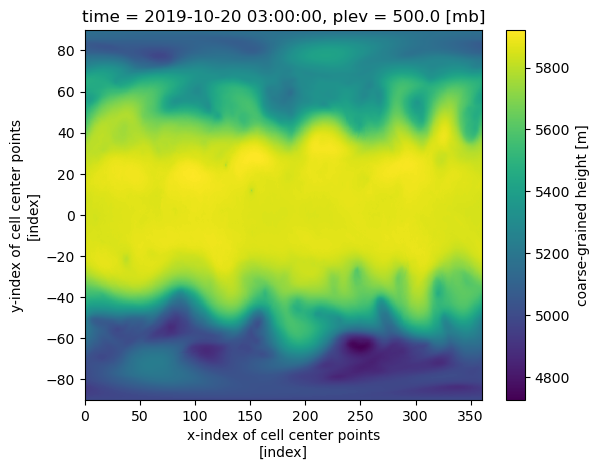

In [16]:
zg500_test.plot()

In [17]:
zg500_djf = zg500.where(zg500['time'].dt.season == 'DJF', drop=True)
zg500_djf_mean = zg500_djf.mean(dim='time')

In [18]:
n_times = zg500_djf.sizes['time']
rand_idx = np.random.randint(n_times)
rand_time = zg500_djf['time'][rand_idx].values
print(rand_time)
zg500_rand = zg500.sel(time=rand_time)

2020-12-02 03:00:00


In [19]:
# test = zg500[0:300,:].load()

In [20]:
anomaly = (zg500 - zg500_djf_mean)#.compute()

In [21]:
# anomaly.compute()
# print(anomaly)

In [22]:
lon, lat = anomaly.grid_xt_coarse, anomaly.grid_yt_coarse

In [23]:
xlon, ylat = np.meshgrid(lon, lat[::-1])

In [24]:
ylat

array([[ 89.875,  89.875,  89.875, ...,  89.875,  89.875,  89.875],
       [ 89.625,  89.625,  89.625, ...,  89.625,  89.625,  89.625],
       [ 89.375,  89.375,  89.375, ...,  89.375,  89.375,  89.375],
       ...,
       [-89.375, -89.375, -89.375, ..., -89.375, -89.375, -89.375],
       [-89.625, -89.625, -89.625, ..., -89.625, -89.625, -89.625],
       [-89.875, -89.875, -89.875, ..., -89.875, -89.875, -89.875]],
      shape=(720, 1440), dtype=float32)

In [25]:
test_lon, test_lat = new_calc_dx_dy(xlon, ylat,shape='WGS84')

In [26]:
# zg500_djf.where((zg500.grid_yt_coarse >= 30) & (zg500.grid_yt_coarse <= 80))

In [27]:
threshold = np.nanstd(zg500_djf.where((zg500.grid_yt_coarse >= 30) & (zg500.grid_yt_coarse <= 80)).values)
print(threshold)

255.4033


In [28]:
from scipy.signal import convolve2d
from scipy.ndimage import label,generate_binary_structure,find_objects
test_s = np.array([[[0, 0, 0], [0,0,0], [0,0,0]],
                   [[1, 1, 1], [1,1,1], [1,1,1]],
                   [[0, 0, 0], [0,0,0], [0,0,0]]])

In [29]:
area2 = test_lon*test_lat

In [30]:
lat30to90N  = np.where((lat >= 30.) & (lat <= 90.))[0]  
domain_nlat = len(lat30to90N)

In [31]:
domain_area = area2[lat30to90N,:]
print(domain_area.shape)
#print(domain_area)

(240, 1440)


In [32]:
#z500
z500_np = anomaly[:,lat30to90N,:]
print(z500_np.shape)
print(z500_np)

(3560, 240, 1440)
<xarray.DataArray 'h_plev_coarse' (time: 3560, grid_yt_coarse: 240,
                                   grid_xt_coarse: 1440)> Size: 5GB
array([[[ 37.260742  ,  37.677734  ,  37.757324  , ...,  34.413086  ,
          35.46924   ,  36.501465  ],
        [ 37.92578   ,  38.561523  ,  39.090332  , ...,  34.995605  ,
          36.05371   ,  37.07715   ],
        [ 38.652344  ,  39.382324  ,  40.035156  , ...,  35.347656  ,
          36.623535  ,  37.7417    ],
        ...,
        [ 19.748535  ,  19.747559  ,  19.746094  , ...,  19.748047  ,
          19.749512  ,  19.75      ],
        [ 19.84961   ,  19.850586  ,  19.850586  , ...,  19.849121  ,
          19.849121  ,  19.850098  ],
        [ 19.830566  ,  19.830566  ,  19.830566  , ...,  19.830566  ,
          19.830566  ,  19.830566  ]],

       [[ 39.035645  ,  39.643555  ,  40.52246   , ...,  37.605957  ,
          38.290527  ,  38.65039   ],
        [ 39.81299   ,  40.1958    ,  40.90869   , ...,  37.981934  ,
     

In [ ]:
z500_anom_filter = anomaly.where(z500_np>threshold).rename({"grid_yt_coarse":"lat","grid_xt_coarse":"lon"})

In [ ]:
z500_anom_bool = ~np.isnan(z500_anom_filter)

In [ ]:
z500_anom_bool[0,:].plot()

In [ ]:
flag = np.empty((z500_np.shape[0],z500_np.shape[1],z500_np.shape[2]),dtype=int)
num_features = np.empty((z500_np.shape[0]),dtype=int)
# for tt in range(ntim):
flag, num_features = label(z500_anom_bool,structure=test_s) #Nr. Areas
#    print(z500_areas.shape)
#     print(num_features)
print(flag.shape)
#print(flag)

for tt in range(z500_np.shape[0]):
        for yy in range(z500_np.shape[1]):
            if flag[tt, yy, 0] > 0 and flag[tt, yy, -1] > 0 and (flag[tt, yy, 0] > flag[tt, yy, -1]):
                # downstream
#                print('check downstream values')
                flag[tt][flag[tt] == flag[tt, yy, 0]] = flag[tt, yy, -1]
            if flag[tt, yy, 0] > 0 and flag[tt, yy, -1] > 0 and (flag[tt, yy, 0] < flag[tt, yy, -1]):
                # upstream
#                print('check upstream values')
                flag[tt][flag[tt] == flag[tt, yy, -1]] = flag[tt, yy, 0]

In [ ]:
ntim = anomaly.shape[0]

In [ ]:
domain_area.shape

In [ ]:
print(ntim)
flag.shape

In [ ]:
import tqdm
from tqdm import tqdm
overlap = 0.5
persistence = 40

for tt in tqdm(range(0,ntim-1), desc = 'tqdm() Progress Bar'):
    num   = 0
    slices = find_objects(flag[tt])
    for slice_ in slices:
        num = num+1
        if slice_ is None:
            continue
        areacon = np.sum(domain_area[slice_][flag[tt][slice_] == num])/1e6 # m^2 to km^2
        
        if areacon < 2e6: # Did not pass the size threshold
            flag[tt][slice_][(flag[tt][slice_] == num)] = 0.
        else:
            areaover_forward = np.sum(domain_area[slice_][(flag[tt][slice_] == num) & (flag[tt+1][slice_] >= 1)])/1e6
            areaover_backward = np.sum(domain_area[slice_][(flag[tt][slice_] == num) & (flag[tt-1][slice_] >= 1)])/1e6

            fraction_backward = (1 / areacon) * areaover_backward
            fraction_forward = (1 / areacon) * areaover_forward 
            
            if fraction_backward != 0 and fraction_forward != 0:
                if (fraction_backward < overlap) or (fraction_forward < overlap):
                    flag[tt][slice_][(flag[tt][slice_] == num)] = 0.
            # decay
            if fraction_backward != 0 and fraction_forward == 0:
                if (fraction_backward < overlap):
                    flag[tt][slice_][(flag[tt][slice_] == num)] = 0.
            # onset
            if fraction_backward == 0 and fraction_forward != 0:        
                if (fraction_forward < overlap):
                    flag[tt][slice_][(flag[tt][slice_] == num)] = 0.

print(flag.shape)

flag_overlap_processed = flag.copy()

In [ ]:
flag_xr = xr.DataArray(flag_overlap_processed,coords=[zg500.time, lat[lat30to90N], lon], dims=['time','lat','lon'])

In [ ]:
np.unique(flag_xr[962,:,:].values)

In [ ]:
flag_xr[962,:,:].plot()

In [ ]:
np.set_printoptions(threshold=10)

In [ ]:
z500_anom_filter[962,:].plot()

In [ ]:
# step 4: persistency
# find features along time axis
print("Apply persistence...")
flag = xr.where(flag_overlap_processed >= 1, 1, 0)
flag, num_features = label(flag, structure=np.array([[[0, 0, 0], [0,1,0], [0,0,0]],[[1, 1, 1], [1,1,1], [1,1,1]],[[0, 0, 0], [0,1,0], [0,0,0]]]))

slices = find_objects(flag)

for tt in range(ntim):
    for yy in range(domain_nlat):
        if flag[tt, yy, 0] > 0 and flag[tt, yy, -1] > 0 and (flag[tt, yy, 0] > flag[tt, yy, -1]):
            # downstream
            slice_ = slices[flag[tt, yy, 0]-1]
            flag[slice_][(flag[slice_] == flag[tt, yy, 0])] = flag[tt, yy, -1]
        if flag[tt, yy, 0] > 0 and flag[tt, yy, -1] > 0 and (flag[tt, yy, 0] < flag[tt, yy, -1]):
            # upstream
            slice_ = slices[flag[tt, yy, -1]-1]
            flag[slice_][(flag[slice_] == flag[tt, yy, -1])] = flag[tt, yy, 0]

# print(flag)
    
# check for persistance, remove features with lifetime < persistance
num=0
for slice_ in find_objects(flag):
    num = num+1
    if slice_ is None:
        #no feature with this flag
        continue
    else:
        print(slice_[0].stop - slice_[0].start)
        print(slice_[0], num)
    if (slice_[0].stop - slice_[0].start) < persistence:
        print("Did not pass persistence test: ", slice_[0].stop - slice_[0].start)
        flag[slice_][(flag[slice_] == num)] = 0
    else:
        print("Passed persistence test: ", slice_[0].stop - slice_[0].start)

print(flag.shape)
np.set_printoptions(threshold=sys.maxsize)
print(len(np.unique(flag)))

In [ ]:
#flag

In [ ]:
flag_final = xr.where(flag >= 1, 1, 0)

In [ ]:
flag_xr = xr.DataArray(flag,coords=[zg500.time, lat[lat30to90N], lon], dims=['time','grid_yt_coarse','grid_xt_coarse'])

In [ ]:
flag_xr_for_plot = xr.DataArray(flag_final,coords=[zg500.time, lat[lat30to90N], lon], dims=['time','grid_yt_coarse','grid_xt_coarse'])

In [ ]:
flag_xr_for_plot[100,:].plot()

In [ ]:
flag_xr_DJF = flag_xr_for_plot.where(zg500['time'].dt.season == 'DJF', drop=True)

In [ ]:
block_DJF_percent = flag_xr_DJF.sum(dim='time')/1025*100

In [ ]:
block_DJF_percent.plot(robust=True)

In [ ]:
flag_xr.attrs['long_name'] = 'Blocking frequency(30-90N) in Xshield24 through anomaly method'
#print(blocking_freq_binary_xr)
flag_dat = flag_xr.to_dataset(name='block_freq')
print(flag_dat)

In [ ]:
z500_np_dat = z500_np.to_dataset(name='z500_anom')

custom_dataset = xr.merge([flag_dat, z500_np_dat])
print(custom_dataset)

In [ ]:
save_nc =False

    if (save_nc):
    
        import os
        new_filename_2 = '/scratch/cimes/mp3238/HACKATHON/xsh24_blocking_freq_ANO_lat30to90N.nc'
        
        if os.path.exists(new_filename_2):
            os.remove(new_filename_2)
            print("original data removed")
        
        print ('saving to ', new_filename_2)
        custom_dataset.to_netcdf(path=new_filename_2,encoding={'block_freq': {'dtype': 'int32'},
                                                                        'z500_anom': {'dtype': 'float32'}})

In [ ]:
test = xr.open_dataset(new_filename_2)

In [ ]:
print(test)

In [ ]:
test2 = test['z500_anom']

In [ ]:
test3 = test['block_freq']

In [ ]:
test3[35,:].plot()

In [ ]:
test2[35,:].plot()

In [ ]:
from blocking_utils import new_calc_dx_dy, run_lifecycle_HW

In [ ]:
lifecycle_test = flag_xr[:,:,:].copy().rename({"grid_yt_coarse":"lat","grid_xt_coarse":"lon"})
print(lifecycle_test.shape)

In [ ]:
len(np.unique(flag_xr))

In [ ]:
np.unique(flag_xr)

In [ ]:
# lifecycle_test = lifecycle_test.rename({"grid_yt_coarse":"lat","grid_xt_coarse":"lon"})

In [ ]:
lifecycle_flag_test = run_lifecycle_HW(lifecycle_test,z500_anom_filter)

In [ ]:
lifecycle_flag_test

In [ ]:
z500_anom_filter.sel(time='2020-12-30 03:00:00').plot()

In [ ]:
save_csv = False
if (save_csv):
    savedir = '/scratch/cimes/mp3238/HACKATHON/'    
    lifecycle_flag_test.to_csv(savedir + 'properties_xsh24_blocking_freq_ANO_lat30to90N.csv',index=False)

In [ ]:
testt = z500_anom_filter.sel(time='2020-12-30 03:00:00').squeeze()

In [ ]:
np.set_printoptions(threshold=10)
print(testt)